In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot  as plt
import json
import pickle

from shapely.geometry import Point
from shapely.geometry import Polygon

In [2]:
 #creo il percorso per raggiungere i dati e il dizionario che li conterrà

from pathlib  import Path
data_path = Path("../data/raw")

files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',
        'weather':'meteotrentino-weather-station-data.json',
        'precip':'precipitation-trentino.csv',
        'precip-avail':'precipitation-trentino-data-availability.csv',
        'SET-1':'SET-nov-2013.csv',
        'SET-2':'SET-dec-2013.csv',
        'SET-lines':'line.csv',
        'twitter':'social-pulse-trentino.geojson',
        'appa':'APPA_inquinamento_aria_Nov_Dec_2013.csv'}

# griglia geografica provincia
dataframe che suddivide tutta la provincia in una griglia con celle di 1 Km^2 identificate da un ID

***GUADAGNERA' COLONNE CON L'AVANZARE DEL PREPROCESSING*** 

In [3]:
df_grid = gpd.read_file(data_path / files['grid'])

# gli aggiungo la colonna  con il centro 
df_grid['center'] = df_grid['geometry'].apply(lambda x:x.centroid)

In [4]:
#griglia non definitiva
df_grid

,cellId,geometry,center
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",POINT (10.92089 45.67740)
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",POINT (10.93372 45.67718)
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",POINT (10.94655 45.67697)
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",POINT (10.90836 45.68661)
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640)
...,...,...,...
6570,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",POINT (11.81103 46.52301)
6571,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",POINT (11.82405 46.52269)
6572,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",POINT (11.79847 46.53232)
6573,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",POINT (11.81149 46.53200)


# dati consumi
voglio un dataframe che per ogni cella attiva (attiva nel senso che si hanno i dati delle linee elettriche solo per le celle attraversate da una linea giustamente, di tutte le altre celle non abbiamo informazioni e quindi le ignoriamo in questo DF) contenente il consumo di ogni cella ora per ora per il corso di entrambi i mesi

In [5]:
SET_1 = gpd.read_file(data_path / files['SET-1'])
SET_2 = gpd.read_file(data_path / files['SET-2'])
SET_lines = gpd.read_file(data_path / files['SET-lines'])


sistemo sia SET che SET_lines e li preparo per un merging intelligentre

In [6]:
SET=SET_1.append(SET_2, ignore_index=True)


# separo la data e aggiungo anche la colonna che indica il giorno della settimana, tornerà utile
def SplitDate(df):
    week = {0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'}
    
    df['year']=df['field_2'].apply(lambda x:x[0:4])
    df['mounth']=df['field_2'].apply(lambda x:x[5:7])
    df['day']=df['field_2'].apply(lambda x:x[8:10])
    df['hour']=df['field_2'].apply(lambda x:x[11:13])
    df['minute']=df['field_2'].apply(lambda x:x[14:16])
    if df['mounth'][0]=='11':
        df['week']=df['day'].apply(lambda x:week[(int(x)+3)%7])
    else:
        df['week']=df['day'].apply(lambda x:week[(int(x)+5)%7])
    
    return df

SET=SplitDate(SET)
SET.drop(columns=['geometry','field_2'],inplace=True)
SET.rename(columns={'field_1':'LINESET','field_3':'CONSUMI'},inplace=True)

SET=SET.astype({'CONSUMI': float})

# ci sbaraziamo subito dei minuti
SET=SET.groupby(['LINESET','year','mounth','day','hour','week']).sum()
SET=SET.reset_index(level=[0,1,2,3,4,5])

In [7]:
# nel DF 'SET_lines' aggiungo una colonna con il numero di ubicazione per linea
# ci sono modi sicuramente più efficenti per farlo...

SET_lines=SET_lines.astype({'NR_UBICAZIONI': int})

prov1=SET_lines.groupby(['LINESET']).sum()
prov1=prov1.reset_index(level=[0])
SET_lines.rename(columns={'NR_UBICAZIONI':'utenze'},inplace=True)

LINES=SET_lines.merge(prov1, how='left', on='LINESET')

procedo con il merging dei due DATAFRAME che mi sono appena preparato, in sostanza fondendoli sotto la colonna 'LINESET' mi si crea un dataframe che per ogni cellId contiene i dati ora per ora di tutte le linee che passavano per quella cella,
*****il DF che ottengo è molto grande e a volte mi blocca il pc*****

In [8]:
MEGASET=SET.merge(LINES, how='left', on='LINESET')
MEGASET['consumi']=MEGASET['utenze']*MEGASET['CONSUMI']/MEGASET['NR_UBICAZIONI']
MEGASET.drop(columns=['NR_UBICAZIONI','CONSUMI','geometry'],inplace=True)

# raggruppo per avere solo informazioni sulle celle e non sulle linee
MEGASET=MEGASET.groupby(['SQUAREID','year','mounth','day','hour','week']).sum()
MEGASET=MEGASET.reset_index(level=[0,1,2,3,4,5])

# ultime sistemazioni
MEGASET['consumi']=MEGASET['consumi'].abs()
MEGASET=MEGASET.astype({'SQUAREID': int})
MEGASET.rename(columns={'SQUAREID':'cellId'},inplace=True)

In [9]:

MEGASET.to_pickle("../data/processed/CONSUMI.pkl")

# dati meteo
è il dataset più brutto: misura **temperetature**, **precipitazioni** e **vento** ogni 15 minuti per una trentina di stazioni meteo sparse per la provincia, solo che viene dedicata una colonna per ogni 15 minuti di rilevazione per ognuna delle tre grandezze, il che è decisamente scomodo visto lo standard degli altri dataframe
**tutti i dati inerenti al vento li ignoro dato che non ho un modo pratico per trattarli oltre ad essere pieni di valori mancanti, in una prima analisi inoltre non avevano mostrato di avere una correlazione rilevante con i consumi energetici**

In [10]:
with open(data_path / files['weather']) as f:
    weather_json = json.load(f)

weather = gpd.GeoDataFrame(weather_json['features'])

In [11]:
# sistemo subito la colonna geometry
weather['geometry'] = weather['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
weather.drop(columns=['geomPoint.geom'],inplace=True)

In [12]:
# inizio separando i tre blocchi con le misure di temperatura  precipitazioni e vento 
temperatures=weather.iloc[:, 9:105]
precipitations=weather.iloc[:, 105:201]

useless=weather.columns[9:297]
weather1=weather.drop(columns=list(useless))

# dato che non mi interessa una precisione superiore droppo tutte le colonne che non sono all'ora spaccata
# quindi 3 colonne su 4

for i in range(96):
    if i%4!=0:
        temperatures.drop(columns=list(useless)[i],inplace=True)
        precipitations.drop(columns=list(useless)[i+96],inplace=True)

In [13]:
# adesso costruisco piano piano il dataframe finale andando a impilare le volonne dei tre blocchi
WEATHER=weather1
TEMP = temperatures.iloc[:, 0]
PREC = precipitations.iloc[:, 0]
hour = pd.DataFrame(0, index=range(len(weather1)), columns=range(1))

for i in range(1,24):
    WEATHER = WEATHER.append(weather1, ignore_index=True)
    TEMP = TEMP.append(temperatures.iloc[:, i], ignore_index=True)
    PREC = PREC.append(precipitations.iloc[:, i], ignore_index=True)
    hour = hour.append(pd.DataFrame(i, index=range(len(weather1)), columns=range(1)),ignore_index=True)
    
WEATHER['temper']=TEMP
WEATHER['precip']=PREC
WEATHER['hour']=hour

# scrivo per esteso la data
def SplitDate2(df):
    df['year']=df['date'].apply(lambda x:x[0:4])
    df['mounth']=df['date'].apply(lambda x:x[5:7])
    df['day']=df['date'].apply(lambda x:x[8:10])
    return df

WEATHER=SplitDate2(WEATHER)
WEATHER.drop(columns=['date','timestamp','elevation','minWind','maxWind','precipitation'], inplace=True)

In [14]:
#purtroppo ci sono dei nan in 'precip' e 'temper' però li lascio li non dovrebbero creare problemi in teoria

In [15]:
WEATHER
WEATHER.to_pickle("../data/processed/WEATHER.pkl")

prima di chiudere con i dati climatici aggiungo al DF 'df_grid' una colonna che identifica per ogni cella l'id della stazione più vicina

In [16]:
# creo il dataframe spot con stationID e posizione
spot = gpd.GeoDataFrame(pd.unique(weather['geometry']))
spot.rename(columns={0:'geometry'},inplace=True)
spot['station']=gpd.GeoDataFrame(pd.unique(weather['station']))

station=[]
for point in df_grid['geometry']:
    minimo=100
    for staz in spot.index:
        dist=point.distance(spot['geometry'][staz])
        if dist < minimo:
            minimo=dist
            min_indx=staz
    station.append(spot['station'][min_indx])

                                            
df_grid['station']=station 

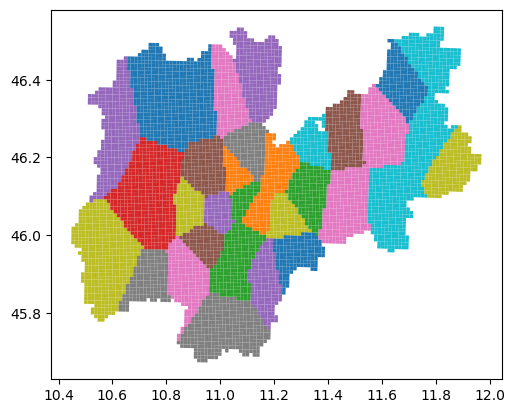

In [17]:
# ecco il risultato
df_grid.plot('station')
plt.show()

# dati precipitazioni
precip ha i dati delle pricipitazioni per ogni cella ogni 10 minuti solo che tante rilevazioni di interi giorni sono totalmente assenti, per questo c'è il DF precip_avail che dovrebbe dire quali rilevazioni sono state effettivamente effettuate, lo stesso la cosa non è molto utile dato che non segna quali celle effettivamente hanno effettuato la registrazione o meno.
considero questo dataframe il meno utile viste le sue carenze, mi limito quindi a considerare per ogni giorno le precipitazioni totali per ogni cella

In [18]:
precip=gpd.read_file(data_path / files['precip'])
precip_avail=gpd.read_file(data_path / files['precip-avail'])

In [19]:
PRECIP=precip_avail.merge(precip, how='left', on='field_1')

def SplitDate3(df):
    df['year']=df['field_1'].apply(lambda x:x[0:4])
    df['mounth']=df['field_1'].apply(lambda x:x[4:6])
    df['day']=df['field_1'].apply(lambda x:x[6:8])
    df['hour']=df['field_1'].apply(lambda x:x[8:10])
    df['minute']=df['field_1'].apply(lambda x:x[10:12])
    return df

PRECIP=SplitDate3(PRECIP)
PRECIP=PRECIP.drop(columns=['field_1','geometry_x','geometry_y'])
PRECIP=PRECIP.astype({"field_3": float})
PRECIP=PRECIP.rename(columns={'field_2_x':'recorded','field_2_y':'cellId','field_3':'precip'})

# riempio tutti i nan con 0 per le precipitazioni e in una cella qualsiasi, alla fine nella somma non
# contribuirà alla cella dato che è zero
PRECIP=PRECIP.fillna(value={'precip':0.0,'cellId':'2383'})

# raggruppo fino ad avere precisione massima giornaliera
PRECIP=PRECIP.groupby(['cellId']+['year']+['mounth']+['day']).sum()
PRECIP=PRECIP.reset_index(level=[0,1,2,3])
PRECIP.sort_values(by=['mounth','day'], ascending = [1,1], inplace = True,ignore_index=True)


In [20]:
PRECIP
PRECIP.to_pickle("../data/processed/PRECIP.pkl")

# dati regionali
dai dati regionali potrei cogliere molte informazioni preziose per la distinzione delle celle della griglia secondo categorie di appartenenza come zone disabitate, paesi,frazioni,citta,zone industriali ecc... il problema è che il dataframe fornito e che dovrebbe contenere i perimetri di ogni località presenta dei seri difetti nel farlo.
a questo proposito sulla base della lista delle località presente in questo dataframe ho scritto una funzione che applicasse una ricerca per nome sul sito 'OpenStreetMap' e da questo ricavasse le coordinate geografiche del centro della località
purtroppo questa funzione anche se in prima approssimazione funziona ottimamente, ha difficoltà ad individuare alcune delle località presenti nella lista.
- quindi per una 60ina di queste ho cercato manualmente su 'google maps' le coordinate geografiche e salvate in una lista
- altra storia per una 20ina di località denominate 'località produttiva' per la quale anche una ricerca diretta con maps si è rivelata fallimentare, ma vista l'importanza di certe aree dal punto di vista dei consumi anche in questo caso mi sono armato di pazienza e navigando a vista sulla mappa satellitare di google maps ho individuato grossomodo le coordinate  i maggiori centri industriali della provincia e li ho salvati in una lista.
- anche il comune di Trento ha avuto problemi quindi a mano ho salvato il poligono che meglio lo rappresentasse sempre prendendo i punti da google maps

il processo ha avuto anche problemi nell'esecuzione e anche per la sua 'artigianalità' mi limito a riportare commentate le funzioni, importando il dataframe già lavorato

## griglia finale
aggiungo due colonne alla griglia, una contenente la popolazione approssimativa per ogni cella e una che categorizzi la cella secondo il modello:
- bc (big city) sopra i 100k ab **celle a mano**
- c (city) sopra 20k ab    **8 celle con consumi sopra 10k**
- bp (big paese) sopra 6k ab  **4 celle con consumi sopra 10k**
- p (paese) sopra 2k ab   **1 con consumi sopra 5k**
- sp (small paese) sopra 500 ab  **1 cella**
- f (frazione) sotto 500 ab  **1 cella**
- i (industriale) livello 80 **1 cella ma ha la priorità**
- a (attiva) se non è vicina a nessuna località tabulata ma ha consumi sopra i 5k
- b (bosco) tutte le altre celle disabitate con bassi consumi

In [21]:
# importo il risultato
REGIONE = pd.read_pickle("../data/processed/REGIONE.pkl")
REGIONE=gpd.GeoDataFrame(REGIONE)
REGIONE.drop(columns=['altPoint','isMountainMunicipality','nameId','elevation','altPoint'], inplace=True)

#############################################################################################################
# mi sono reso conto che ho celle che hanno lo stesso nome, quindi adesso scrivo una funzione che sistema sto fattaccio 
# tenendo un solo comune e sommandone gli abitanti
def reggruppo(df):
    df.sort_values(by=['name'], ascending = [1], inplace = True,ignore_index=True)
    for i in range(1, len(df)):
        if df['name'][i]==df['name'][i-1]:
            df['population'][i]+=df['population'][i-1]
            df.drop([i-1], inplace=True)
    df = df.reset_index(drop=True)
    df.sort_values(by=['population'], ascending = [1], inplace = True,ignore_index=True)
    return df

REGIONE=reggruppo(REGIONE)

############################################################################################################
# classifico le varie località secondo quanto detto prima
conditions = [
    (REGIONE['level']!=80) & (REGIONE['population']>=100000),
    (REGIONE['level']!=80) & ((REGIONE['population']>=20000) & (REGIONE['population']<100000)),
    (REGIONE['level']!=80) & ((REGIONE['population']>=6000) & (REGIONE['population']<20000)),
    (REGIONE['level']!=80) & ((REGIONE['population']>=2000) & (REGIONE['population']<6000)),
    (REGIONE['level']!=80) & ((REGIONE['population']>=500) & (REGIONE['population']<2000)),
    (REGIONE['level']!=80) & (REGIONE['population']<500),
    (REGIONE['level']==80)    
    ]
values = ['bc','c','bp','p','sp','f','i']

REGIONE['category'] = np.select(conditions,values)


#########################################################################################################à
#devo sostituire la geometry di trento in un poligono 
trento=[
    (46.027298592522236, 11.117985791702225),
    (46.039254334368444, 11.157835140027546),
    (46.05426485833212, 11.154430924341462),
    (46.057461017172756, 11.138611333800254),
    (46.06968809092677, 11.141014309578665),
    (46.09566163205769, 11.135807861711651),
    (46.11454379960005, 11.110376367910641),
    (46.09635594417185, 11.095157521314036),
    (46.0794122391796, 11.109975872459122),
    (46.048566899308845, 11.111778104439088)
]

<ipython-input-21-aee118a91da3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['population'][i]+=df['population'][i-1]


In [22]:
# raggruppo
griglia=MEGASET.groupby(['cellId']).sum()
griglia.drop(columns=['utenze'], inplace=True)
griglia=griglia.reset_index(level=[0])

# fondo per avere i dati geometrici
griglia=df_grid.merge(griglia, how='left', on='cellId')
griglia=griglia.fillna(0) #metto a zero i consumi delle celle non presenti in MEGASET che compaiono del merging

# creo le due colonne che mi interessavano
griglia['category']=np.nan
griglia['population']=np.zeros(len(griglia))


In [23]:
#in sta sezione associo ad ogni cella la sua categoria in base alla vicinanza a località in 'REGIONE'
#ho seguito alcuni criteri per cercare di essere il più preciso possibile tra i quali cercare solo in celle 
#che abbiano un minimo di attivià di consumo e dando la priorità a zone industriali e ai grandi centri 
from shapely.ops import transform
import heapq

for i in REGIONE.index:
    punto=transform(lambda x, y: (y, x), REGIONE['geometry'][i])
    if REGIONE['category'][i] == 'bc':
        polygon = transform(lambda x, y: (y, x),Polygon(trento))
        for j in griglia.index:
            ind=[]
            if polygon.contains(griglia['center'][j]):
                ind.append(j)
            for k in ind:
                if griglia['category'][k] != 'i':
                    griglia['category'][k]='bc'
                griglia['population'][k]+=REGIONE['population'][i]//len(ind)             
    elif REGIONE['category'][i] == 'c':
        #piglio le 9 celle più vicine
        dist=[]
        for j in griglia.index:
            if griglia['consumi'][j]>1:
                dist.append(griglia['center'][j].distance(punto))
            else:
                dist.append(100)
        s_dist=heapq.nsmallest(30, dist)
        count=0
        for k in s_dist:
            ind=dist.index(k)
            if griglia['consumi'][ind]>10000:
                if griglia['category'][ind] != 'i':
                    griglia['category'][ind]='c'
                griglia['population'][ind]+=REGIONE['population'][i]//8
                count+=1
                if count==8:
                    break
    elif REGIONE['category'][i] == 'bp':
        #piglio le 4 celle più vicine
        dist=[]
        for j in griglia.index:
            if griglia['consumi'][j]>1:
                dist.append(griglia['center'][j].distance(punto))
            else:
                dist.append(100)
        s_dist=heapq.nsmallest(20, dist)
        count=0
        for k in s_dist:
            ind=dist.index(k)
            if griglia['consumi'][ind]>10000:
                if griglia['category'][ind] != 'i':
                    griglia['category'][ind]='bp'
                griglia['population'][ind]+=REGIONE['population'][i]//4
                count+=1
                if count==4:
                    break

    elif REGIONE['category'][i] == 'p':
        dist=[]
        for j in griglia.index:
            if griglia['consumi'][j]>1:
                dist.append(griglia['center'][j].distance(punto))
            else:
                dist.append(100)
        s_dist=heapq.nsmallest(20, dist)
        # trovare la prima cella più vicina con consumi superiori a 5000 (arbitrario)
        for k in s_dist:
            ind=dist.index(k)
            if griglia['consumi'][ind]>5000:
                if griglia['category'][ind] != 'i':
                    griglia['category'][ind]='p'
                griglia['population'][ind]+=REGIONE['population'][i]
                break

    else:
        #piglio la celle più vicina
        dist=[]
        indici=[]
        for j in griglia.index:
            if griglia['consumi'][j]>1:
                dist.append(griglia['center'][j].distance(punto))
            else:
                dist.append(100)           
        ind=dist.index(min(dist)) 
        if griglia['category'][ind] != 'i':
            griglia['category'][ind]=REGIONE['category'][i]
        griglia['population'][ind]+=REGIONE['population'][i]

# tutte le celle rimaste senza category le distinguo in 'b' (bosco) a basso consumo
# 'a' (attive) se hanno un consumo superiore a 5000
for i in griglia.index:  
    if pd.isnull(griglia['category'][i]):
        if griglia['consumi'][i]>5000:
            griglia['category'][i]='a'
        else:
            griglia['category'][i]='b'
            
    


<ipython-input-23-f09008f69007>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  griglia['category'][ind]=REGIONE['category'][i]
C:\Users\Paolo\anaconda3\envs\DataMining\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-23-f09008f69007>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  griglia['population'][ind]+=REGIONE['popula

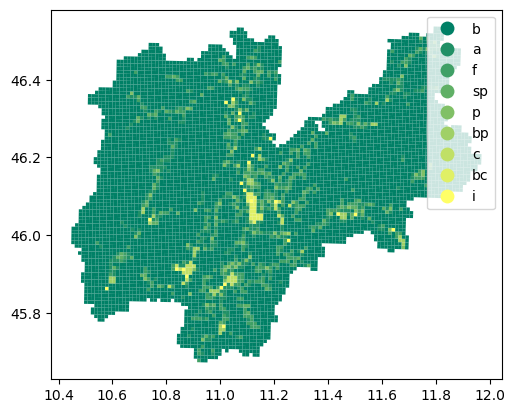

In [24]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#006600', '#00ff00', '#0099ff','#6600ff', '#cc00ff','#cc0000', '#ff9933','#ffff00', 'k'])
griglia.plot('category',categories=['b','a','f','sp','p','bp','c','bc','i'],legend=True,cmap='summer')
plt.show()
griglia
griglia.to_pickle("../data/processed/GRID.pkl")

## dati APPA

In [25]:
appa=gpd.read_file(data_path / files['appa'])
# tengo solo i dati relativi a trento quindi parco s.Chiara e via Bolzano
appa=appa.drop(appa[(appa['Stazione'] == 'Borgo Valsugana') | (appa['Stazione'] == 'Rovereto') | (appa['Valore'] == 'n.d.')].index)
# adesso trasformo tuuti i valori in migrogrammi/mc
appa=appa.astype({"Valore": float})
for i in list(appa[appa['Unità di misura']=='mg/mc'].index):
    appa['Valore'][i]=appa['Valore'][i]*1000
    
# uniamo per giorno e inquinante e stazione
appa=appa.groupby(['Inquinante','Data']).mean()
appa=appa.reset_index(level=[0,1])

appa['mounth']=appa['Data'].apply(lambda x:x[5:7])
appa['day']=appa['Data'].apply(lambda x:x[8:10])

# devo prendermi i consumi di trento per tutti e 61 i giorni
trento_city=griglia[griglia['category']=='bc'].loc[:,['cellId']]
trento_city=trento_city.merge(MEGASET, how='left', on='cellId')
trento_city=trento_city.groupby(['mounth','day']).sum()
trento_city=trento_city.reset_index(level=[0,1])

# e attaccari al dataframe dell'inquinamento
appa=appa.merge(trento_city, how='left', on=['mounth','day'])
#droppo le colonne inutili
appa.drop(columns=['cellId', 'Data','utenze'],inplace=True)

<ipython-input-25-c2484a7c163b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appa['Valore'][i]=appa['Valore'][i]*1000


In [26]:
APPA=appa.loc[0:60,['mounth','day','consumi']]
APPA['BiOss. zolfo']=list(appa['Valore'][0:61])
APPA['BiOss. azoto']=list(appa['Valore'][61:122])
APPA['Oss. carbonio']=list(appa['Valore'][122:183])
APPA['Ozono']=list(appa['Valore'][183:244])
APPA['PM10']=list(appa['Valore'][244:305])
APPA['PM2.5']=list(appa['Valore'][305:366])

In [27]:
APPA
APPA.to_pickle("../data/processed/APPA.pkl")